In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [34]:
from main import *

100%|██████████| 5000/5000 [04:41<00:00, 17.75it/s]


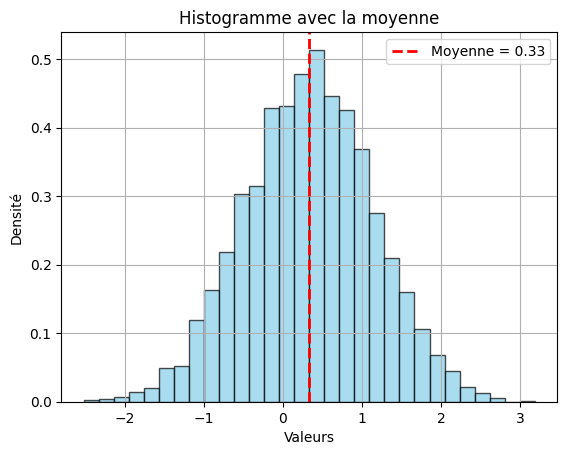

In [4]:
if __name__ == "__main__":
    d = 1  # Dimension
    m = np.ones(d)
    v = 2*np.eye(d)

    x_init = np.random.randn(d)
    n_iter = 1000
    n_points = 5000


    samples  = np.array([elliptical_slice_sampling(x_init, m, v, n_iter)[-1] for _ in tqdm(range(n_points))])

    plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mean_value = np.mean(samples) 

    # Afficher
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

# Ajouter titre et légende
    plt.title("Histogramme avec la moyenne")
    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.show()

### Common random number coupling

In [35]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2


def coupled_transition(x1, x2, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_p_x1, log_p_x2 = log_likelihood(x1, m, v), log_likelihood(x2, m, v)
    log_y_1 = log_p_x1 + np.log(np.random.uniform(0, 1))
    log_y_2 = log_p_x2 + np.log(np.random.uniform(0, 1))

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_1, proposal_2 = x1 * np.cos(theta) + w * np.sin(theta),  x2 * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_1, log_p_proposal_2 = log_likelihood(proposal_1, m, v), log_likelihood(proposal_2, m, v)

    while log_p_proposal_1 <= log_y_1 and log_p_proposal_2 <= log_y_2 :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal_1, proposal_2 = x1 * np.cos(theta) + w * np.sin(theta),  x2 * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_1, log_p_proposal_2 = log_likelihood(proposal_1, m, v), log_likelihood(proposal_2, m, v)

    return proposal_1, proposal_2


def coupled_ess(x1, x2, m, v, n_iter):
    samples = [(x1, x2)]
    x, y = x1, x2

    for i in range(1, n_iter + 1):
        x, y = coupled_transition(x, y, m, v)
        samples.append((x, y))

    return samples

In [39]:
if __name__ == "__main__":
    m, v = 1, 2

    x1, x2 = -1, 1
    n_iter = 1000

    samples = coupled_ess(x1, x2, m, v, n_iter)

In [40]:
x_sample = np.array([samples[i][0] for i in range(len(samples))])
y_sample = np.array([samples[i][1] for i in range(len(samples))])
meet_time = []
for i in range(len(samples)):
    if x_sample[i]==y_sample[i]:
        meet_time.append(i)

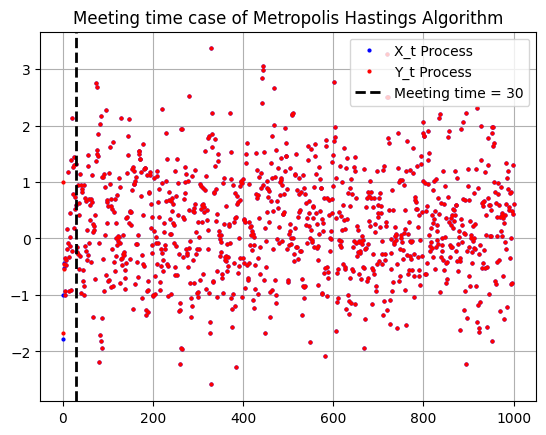

In [41]:
x = np.arange(len(samples))
plt.plot(x, x_sample, marker='o', linestyle='None', markersize=2, color='blue', label = 'X_t Process')
plt.plot(x, y_sample, marker='o', linestyle='None', markersize=2, color='red', label = 'Y_t Process')
plt.axvline(meet_time[0], color='black', linestyle='dashed', linewidth=2, label=f'Meeting time = {meet_time[0]}')
plt.title("Meeting time case of Metropolis Hastings Algorithm")
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:50<00:00, 29.35it/s]


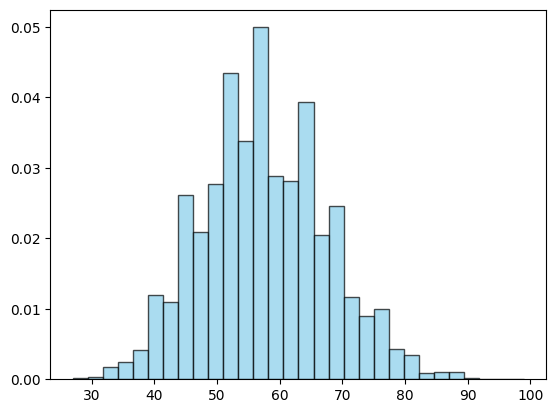

In [43]:
if __name__ == "__main__":
    m, v = 1, 2

    x1, x2 = -1, 1
    n_iter = 1000
    N = 5000

    meet_time = []

    for _ in tqdm(range(N)):
        samples = coupled_ess(x1, x2, m, v, n_iter)
        x_sample = np.array([samples[i][0] for i in range(len(samples))])
        y_sample = np.array([samples[i][1] for i in range(len(samples))])
        i = 0
        while x_sample[i] != y_sample[i]:
            i += 1
        meet_time.append(i)
    
    plt.hist(meet_time, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.show()

### Transition distribution

In [51]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2

def transition(x, m, v):
    """
    One step of Elliptical Slice Sampling (ESS)
    
    Parameters:
        x (np.ndarray): Current state
        m (np.ndarray): Mean of Gaussian target
        v (np.ndarray): Covariance of Gaussian target
        
    Returns:
        np.ndarray: New sample from the ESS transition
    """

    w = np.random.normal(0, 1)  # w ~ N(0, I)
    
    log_p_x = log_likelihood(x, m, v)
    log_y = log_p_x + np.log(np.random.uniform(0, 1))  # Slice threshold

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal = log_likelihood(proposal, m, v)

    # Shrinkage loop
    while log_p_proposal <= log_y:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal = log_likelihood(proposal, m, v)

    return proposal


100%|██████████| 50000/50000 [00:00<00:00, 52136.29it/s]


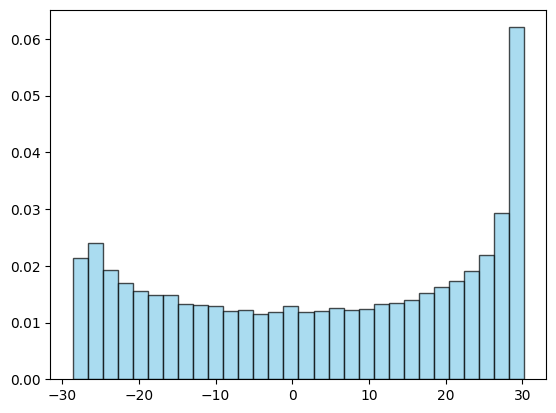

In [123]:
if __name__ == "__main__":
    m, v = 1, 2
    x = 30
    N = 50000

    sample = [transition(x, m, v) for _ in tqdm(range(N))]
    plt.hist(sample, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.show()

In [117]:
print(np.mean(np.array(sample)), np.std(np.array(sample)))

0.2996287562994702 0.6614242750912249
